<a href="https://colab.research.google.com/github/blackhespy/asian-option-ann/blob/main/pricing_asian_option.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Skripsi**

Ditulis oleh Christian Jauhari (6161901028)

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 16.1 MB/s 


In [ ]:
# Import packages
import pylab
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from scipy.stats import lognorm
import matplotlib.pyplot as plt

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy.stats import lognorm
import scipy.stats as stats
import pylab
import statistics as sta

# Input Parameter

In [ ]:
#N: number of random options
N = 5

#Make the same random numbers every time using seed
random.seed(42)

#initial stock prices (uniform distribution)
S = np.random.uniform(70,120,N)

#Time maturity 7 day to 365 days (converted to year)
T = np.random.randint(1,250, N) / 250

#Strike Price
K = np.random.randint(80,120,N)/ 100 * S

#Time remaining untill maturity
T_2 = T
#for k in range(0,N):
  #T2 = np.random.randint(1,T[k]*365) / 365
  #T_2.append(T2)

#Risk free rate (0.01 to 0.05)
r = np.random.randint(100, 500, N) / 10000

#volatility (5% to 50%)
sigma = np.random.randint(5, 50, N) / 100

#average stock prices untill (T-T_2)
dT = 1/250
#A = np.random.uniform(20,200,N)
A = lognorm(0.164, loc = -18.376, scale = 112.610).rvs(size=N)


# Benchmark Calculation


In [ ]:
%%time
def MC_benchmark(S,K,T,r,sigma,dT,M):
  plt.figure(figsize=(8,8))
  M_new = int(1/2*M)
  A_new = []
  A_t = []
  S_t = []
  C = []
  C_akhir = []
  for i in range (0,len(S)):
    C=[]
    for j in range(0,M_new):
        path2 = [S[i]]
        path1 = [S[i]]
        temp1 = S[i]
        temp2 = S[i]

        for k in range(1,int(T[i]/dT)):
          epsilon = np.random.normal(0,1)
          temp1 = temp1 * np.exp(((r[i] - ((sigma[i] ** 2) / 2)) * dT) + (sigma[i] * epsilon * np.sqrt(dT)))
          path1.append(temp1)
          temp2 = temp2 * np.exp(((r[i] - ((sigma[i] ** 2) / 2)) * dT) + (sigma[i] * -epsilon * np.sqrt(dT)))
          path2.append(temp2)
        A_1 = np.mean(path1)
        A_2 = np.mean(path2)
        plt.plot(np.arange(0,T[i]/dT),path1)
        plt.plot(np.arange(0,T[i]/dT),path2)
        C.append( np.exp(-r[i]*T[i])*np.maximum(A_1-K[i],0) )
        C.append( np.exp(-r[i]*T[i])*np.maximum(A_2-K[i],0) )
    C_akhir.append(np.average(C))
  return (C_akhir)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.1 µs


CPU times: user 54.5 ms, sys: 97 µs, total: 54.6 ms
Wall time: 307 ms


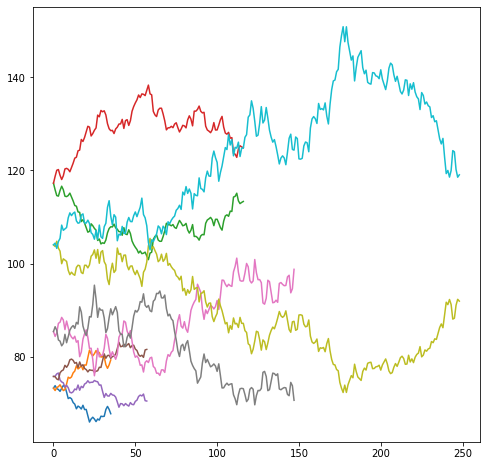

In [ ]:
%%time
Benchmark = MC_benchmark(S,K,T,r,sigma,dT,2)

In [ ]:
Asian_MC = pd.DataFrame({'S': S,
                              'K': K,
                              'r': r,
                              'T' : T,
                              'sigma': sigma,
                              'C Asia' : Benchmark,
                              })
Asian_MC

# Levy Approximation

Black-Scholes Asia Approximation Solution

In [ ]:
def bsm_call_asia(S, K, A, T, T_2, r, sigma):
  global v
  global S_Z
  global K_Z
  global L
  global d1
  global d2
  M = 2*S**2/(r+sigma**2)*( ((np.exp((2*r+sigma**2)*T_2)-1)/(2*r+sigma**2)) - ((np.exp(r*T_2)-1) / r) )
  L = M/T**2
  S_Z = S/(r*T)*(1-np.exp(-r*T_2))
  K_Z = K - (A*(T-T_2)/T)
  v = np.log(L) -2*(r*T_2 + np.log(S_Z))
  d1 = 1/np.sqrt(v)*(np.log(L)/2 - np.log(np.abs(K_Z)))
  d2 = d1 - np.sqrt(v)

  return S_Z * norm.cdf(d1) - K_Z * np.exp(-r*T_2) * norm.cdf(d2)

In [ ]:
%%time
levy = [bsm_call_asia(S[i], K[i], A[i], T[i], T_2[i], r[i], sigma[i]) for i in range (N)]
Asian_Levy = pd.DataFrame({'S': S,
                              'K': K,
                              'A': A,
                              'T': T,
                              'T_2' : T_2,
                              'r': r,
                              'sigma': sigma,
                              'C Asia' : levy
                              })
Asian_Levy

CPU times: user 31.5 ms, sys: 9.23 ms, total: 40.8 ms
Wall time: 35.7 ms


,S,K,A,T,T_2,r,sigma,C Asia
0,96.341299,79.963278,62.874017,0.160,0.160,0.0497,0.31,16.637028
1,80.131500,76.124925,79.751838,0.732,0.732,0.0221,0.31,7.373768
2,118.535739,126.833241,120.958765,0.960,0.960,0.0438,0.26,4.599012
3,89.189666,101.676220,103.103296,0.600,0.600,0.0129,0.44,2.940123
4,103.227648,103.227648,106.415967,0.356,0.356,0.0341,0.06,1.191671
...,...,...,...,...,...,...,...,...
95,91.256425,98.556939,173.005011,0.688,0.688,0.0131,0.42,4.664041
96,108.686971,102.165753,89.218828,0.228,0.228,0.0122,0.17,6.856013
97,116.729019,105.056117,96.619856,0.012,0.012,0.0344,0.34,11.692171
98,110.491514,128.170156,85.654162,0.036,0.036,0.0470,0.31,0.000006


## Calculating Error Levy with Benchmark

In [ ]:
mae = metrics.mean_absolute_error(levy, Benchmark)
mse = metrics.mean_squared_error(levy, Benchmark)
r2 = metrics.r2_score(levy, Benchmark)

In [ ]:
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.10053621301639241
MSE: 0.026414443179545125
R-Squared: 0.999201153209507


# Sobol Sequence

In [ ]:
%%time
# SOBOL SEQUENCE
def Sobol(S,K,T,r,sigma,dT):
  sobol = stats.qmc.Sobol(d=1, scramble=False )
  sobol_seq = sobol.random_base2(m=8)
  sobol_transform = [ norm.ppf(sobol_seq[i][0]) for i in range (0,len(sobol_seq))]
  sobol_transform[0] = 0.00001
  A_new = []
  A_t = []
  S_t = []
  C = []
  quasi = sobol_transform
  for j in range (0,len(S)):
      path1 = [S[j]]
      temp1 = S[j]

      for i in range(1,int(T[j]/dT)):
        if i > 255:
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * quasi[i-256] * np.sqrt(dT)))
        else:
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * quasi[i] * np.sqrt(dT)))
        path1.append(temp1)
      S_t.append(temp1)
      A_1 = np.mean(path1)
      A_t.append(A_1)
      C.append( np.exp(-r[j]*T[j])*np.maximum(A_1-K[j],0) )
  return (C,A_t)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 24.6 µs


In [ ]:
%%time
# SOBOL SEQUENCE SCRAMBLED
def Sobol_scramble(S,K,T,r,sigma,dT):
  global sobol_all
  sobol_all = []
  for a in range (0,len(S)):
    sobol = stats.qmc.Sobol(d=1 , scramble=True)
    sobol_seq = sobol.random_base2(m=8)
    quasi = [ norm.ppf(sobol_seq[i][0]) for i in range (0,len(sobol_seq))]
    sobol_all.append(quasi)
  A_new = []
  A_t = []
  S_t = []
  C = []


  for j in range (0,len(S)):
      path1 = [S[j]]
      temp1 = S[j]
      for i in range(1,int(T[j]/dT)):
        if i > 255 :
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * sobol_all[j][i-256] * np.sqrt(dT)))
        else:
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * sobol_all[j][i] * np.sqrt(dT)))
        path1.append(temp1)
      S_t.append(temp1)
      A_1 = np.mean(path1)
      A_t.append(A_1)
      C.append( np.exp(-r[j]*T[j])*np.maximum(A_1-K[j],0) )
  return (C,A_t)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [ ]:
%%time
# SOBOL SEQUENCE SCRAMBLED BERULANG
def Sobol_berulang(S,K,T,r,sigma,dT,M):
  global sobol_all
  #plt.figure(figsize=(8,8))
  sobol_all = []
  for a in range (0,int(M*1)):
    sobol = stats.qmc.Sobol(d=1 , scramble=True)
    sobol_seq = sobol.random_base2(m=8)
    quasi = [ norm.ppf(sobol_seq[i][0]) for i in range (0,len(sobol_seq))]
    sobol_all.append(quasi)
  S_t = []
  C=[]
  C_akhir =[]
  A_t = []
  for j in range (0,1):
    for k in range(0,M):
      path1 = [S[j]]
      temp1 = S[j]
      for i in range(1,int(T[j]/dT)):
        if i > 255 :
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * sobol_all[M*j+k][i-256] * np.sqrt(dT)))
        else:
          temp1 = temp1 * np.exp(((r[j] - ((sigma[j] ** 2) / 2)) * dT) + (sigma[j] * sobol_all[M*j+k][i] * np.sqrt(dT)))
        path1.append(temp1)
      #plt.plot(np.arange(0,T[j]/dT),path1)
      S_t.append(temp1)
      A_1 = np.mean(path1)
      A_t.append(A_1)
      C.append( np.exp(-r[j]*T[j])*np.maximum(A_1-K[j],0) )
    C_akhir.append(np.average(C))
  return (C_akhir,A_t)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


In [ ]:
%%time
Sobol_original = Sobol(S,K,T,r,sigma,dT)

CPU times: user 77.1 ms, sys: 0 ns, total: 77.1 ms
Wall time: 77.8 ms


In [ ]:
%%time
Sobol_scramble = Sobol_scramble(S,K,T,r,sigma,dT)

TypeError: ignored

In [ ]:
%%time
M=1000
Sobol_berulan = Sobol_berulang(S_p,K_p,T_p,r_p,sigma_p,dT,M)

CPU times: user 25.3 s, sys: 136 ms, total: 25.5 s
Wall time: 26.1 s


In [ ]:
max(Sobol_berulan[1])

112.3599362209213

In [ ]:
Asian_Sobol = pd.DataFrame({'S': S,
                              'K': K,
                              'T': T,
                              'r': r,
                              'sigma': sigma,
                              'A Sobol Original' : Sobol_original[1],
                              'C Asia Sobol Original' : Sobol_original[0],
                              'A Sobol Scrambled' : Sobol_scramble[1],
                              'C Asia Sobol Scrambled' : Sobol_scramble[0],
                              })
Asian_Sobol

,S,K,T,r,sigma,A Sobol Original,C Asia Sobol Original,A Sobol Scrambled,C Asia Sobol Scrambled
0,96.341299,79.963278,0.160,0.0497,0.31,96.808902,16.712198,96.017892,15.927454
1,80.131500,76.124925,0.732,0.0221,0.31,79.942085,3.755905,79.194457,3.020275
2,118.535739,126.833241,0.960,0.0438,0.26,120.375966,0.000000,118.756325,0.000000
3,89.189666,101.676220,0.600,0.0129,0.44,87.856130,0.000000,87.002413,0.000000
4,103.227648,103.227648,0.356,0.0341,0.06,103.921258,0.685241,103.815255,0.580518
...,...,...,...,...,...,...,...,...,...
95,91.256425,98.556939,0.688,0.0131,0.42,89.592855,0.000000,88.745828,0.000000
96,108.686971,102.165753,0.228,0.0122,0.17,109.205563,7.020255,108.506670,6.323303
97,116.729019,105.056117,0.012,0.0344,0.34,117.286442,12.225277,114.876934,9.816764
98,110.491514,128.170156,0.036,0.0470,0.31,110.846805,0.000000,109.460530,0.000000


In [ ]:
%%time
Asian_MC = pd.DataFrame({'S': [S[i] for i in range (0,N) for j in range(0,M) ],
                              #'K': [K[i] for i in range (0,N) for j in range(0,M) ],
                              'St' : CA[2],
                              #'A': CA[1],
                              'T': [T[i] for i in range (0,N) for j in range(0,M) ],
                              'r': [r[i] for i in range (0,N) for j in range(0,M) ],
                              'sigma': [sigma[i] for i in range (0,N) for j in range(0,M) ],
                              'C Asia' : CA[0]
                              })

## Calculating Error Sobol with Benchmark

### Sobol Original

In [ ]:
mae = metrics.mean_absolute_error(Sobol_original[0], Benchmark)
mse = metrics.mean_squared_error(Sobol_original[0], Benchmark)
r2 = metrics.r2_score(Sobol_original[0], Benchmark)

In [ ]:
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.038330735384511
MSE: 10.282270204345323
R-Squared: 0.7944119806224363


### Sobol Scrambled

In [ ]:
mae = metrics.mean_absolute_error(Sobol_scramble[0], Benchmark)
mse = metrics.mean_squared_error(Sobol_scramble[0], Benchmark)
r2 = metrics.r2_score(Sobol_scramble[0], Benchmark)

In [ ]:
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.6349136283461583
MSE: 14.258619569954524
R-Squared: 0.683253428929731


# ANN

In [ ]:
def number_of_layers_neurons(Layers, Neurons, activate, patience):
  #make model a global variable so we can call it outside the function
  global model, history

  #build the model given a number of layers using keras from tensorflow
  if Layers == 2:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation=activate, input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation=activate),
    #Output layer
    keras.layers.Dense(1)
    ])

  elif Layers == 3:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation=activate, input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 3
    keras.layers.Dense(Neurons, activation=activate),
    #Output layer
    keras.layers.Dense(1)
    ])
  elif Layers == 4:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation=activate, input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 3
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 4
    keras.layers.Dense(Neurons, activation=activate),
    #Output layer
    keras.layers.Dense(1)
    ])
  elif Layers == 5:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation=activate, input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 3
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 4
    keras.layers.Dense(Neurons, activation=activate),
    #Hidden layer 5
    keras.layers.Dense(Neurons, activation=activate),
    #Output layer
    keras.layers.Dense(1)
    ])
  else:
    print("Invalid amount of Layers! Choose 1-5")
    return

  #compile the model
  model.compile(loss="mean_squared_error",optimizer="adam",metrics = tfa.metrics.r_square.RSquare())

  #Stop training if cost function (val_loss) using cross validation data fails to decrease.
  callbacks_list = EarlyStopping(monitor = 'val_loss', patience = patience)

  #train the model
  history = model.fit(X_train, y_train, epochs=200,
                      validation_data=(X_valid, y_valid),
                      verbose = 2,callbacks=[callbacks_list]
                      )

In [ ]:
%%time
#Generate option prices for all the random option values


#N: number of random options
N = 1000000

#Make the same random numbers every time using seed
random.seed(42)

#initial stock prices (uniform distribution)
S = np.random.uniform(70,120,N)

#Time maturity 7 day to 365 days (converted to year)
T = np.random.randint(1,250, N) / 250

#Strike Price
K = np.random.randint(80,120,N)/ 100 * S

#Time remaining untill maturity
#for k in range(0,N):
  #T2 = np.random.randint(1,T[k]*365) / 365
  #T_2.append(T2)

#Risk free rate (0.01 to 0.05)
r = np.random.randint(100, 500, N) / 10000

#volatility (5% to 50%)
sigma = np.random.randint(5, 50, N) / 100

#average stock prices untill (T-T_2)
dT = 1/250
#A = np.random.uniform(20,200,N)
A = lognorm(0.164, loc = -18.376, scale = 112.610).rvs(size=N)


Asian_Levy = pd.DataFrame({'S': S,
                              'K': K,
                              'A': A,
                              'T': T,
                              'r': r,
                              'sigma': sigma,
                              'C Asia' : [bsm_call_asia(S[i], K[i], A[i], T[i], T[i], r[i], sigma[i]) for i in range (N)]
                              })

#For us to use the Sklearn model "train_test_split" we need to make a dataframe into a numpy array
call_levy = Asian_Levy.values

#First split the input variable and output variable from each other
#input values
X = call_levy[:, :6]
#output values
y = call_levy[:, 6:7]

# 70% for training, 10% for testing and 20% for validating
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

# Before standardize we want to store X_test[0] and y_test[0] value
input_test = X_test[0]
output_test = y_test[0]

#We standardize our data using sklearn.preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

layers = 2
neurons = 50
number_of_layers_neurons(Layers=layers, Neurons=neurons, activate='ReLU',patience=5)

model.evaluate(X_test,y_test)

(700000, 6) (700000, 1)
(200000, 6) (200000, 1)
(100000, 6) (100000, 1)
Epoch 1/200
21875/21875 - 42s - loss: 0.3773 - r_square: 0.9906 - val_loss: 0.0030 - val_r_square: 0.9999 - 42s/epoch - 2ms/step
Epoch 2/200
21875/21875 - 43s - loss: 0.0027 - r_square: 0.9999 - val_loss: 0.0021 - val_r_square: 0.9999 - 43s/epoch - 2ms/step
Epoch 3/200
21875/21875 - 44s - loss: 0.0020 - r_square: 0.9999 - val_loss: 0.0017 - val_r_square: 1.0000 - 44s/epoch - 2ms/step
Epoch 4/200
21875/21875 - 40s - loss: 0.0017 - r_square: 1.0000 - val_loss: 0.0012 - val_r_square: 1.0000 - 40s/epoch - 2ms/step
Epoch 5/200
21875/21875 - 42s - loss: 0.0015 - r_square: 1.0000 - val_loss: 6.1811e-04 - val_r_square: 1.0000 - 42s/epoch - 2ms/step
Epoch 6/200
21875/21875 - 43s - loss: 0.0014 - r_square: 1.0000 - val_loss: 0.0015 - val_r_square: 1.0000 - 43s/epoch - 2ms/step
Epoch 7/200
21875/21875 - 38s - loss: 0.0012 - r_square: 1.0000 - val_loss: 7.0571e-04 - val_r_square: 1.0000 - 38s/epoch - 2ms/step
Epoch 8/200
21875

[0.0005554996314458549, 0.9999861717224121]

In [ ]:
#If you want to check that it indeed does have the descired amount of layers and neurons
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                400       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


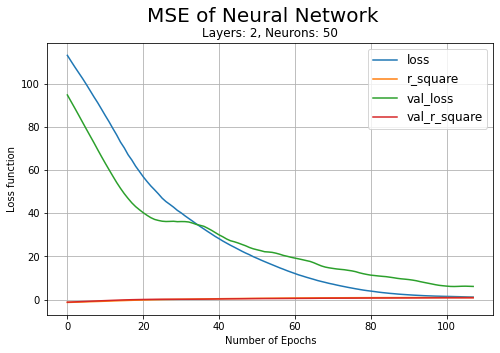

In [ ]:
def plot():
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.xlabel('Jumlah Epoch')
  plt.ylabel('Fungsi Loss')
  plt.suptitle('MSE dari Neural Network', fontsize=20)
  plt.title('Layers: {}, Neurons: {}'.format(layers,neurons))
  plt.legend(loc="upper right", fontsize=12)
  #plt.axis([0, 100, 0, 25])
  plt.show()

plot()

## Model Prediction

In [ ]:
N = 100
S = np.random.uniform(70,120,N)
T = np.random.randint(1,250, N) / 250
K = np.random.randint(80,120,N)/ 100 * S
T_2 = T
r = np.random.randint(100, 500, N) / 10000
sigma = np.random.randint(5, 50, N) / 100
A = lognorm(0.164, loc = -18.376, scale = 112.610).rvs(size=N)

In [ ]:
x_predict = [ [ S[i],K[i],A[i],T[i],T_2[i],r[i],sigma[i] ] for i in range(N) ]

In [ ]:
x_predict = scaler.fit_transform(x_predict)

In [ ]:
%%time
model.predict(x_predict)

4/4 [==============================] - 0s 3ms/step
CPU times: user 75.6 ms, sys: 1.87 ms, total: 77.5 ms
Wall time: 89.4 ms


array([[ 7.110676  ],
       [13.95845   ],
       [13.540936  ],
       [ 4.795855  ],
       [14.263575  ],
       [ 7.4723516 ],
       [ 8.8687315 ],
       [12.748273  ],
       [ 9.778328  ],
       [ 1.2761683 ],
       [11.620373  ],
       [ 9.89123   ],
       [11.489904  ],
       [ 9.449592  ],
       [ 8.128051  ],
       [ 7.1984286 ],
       [ 0.24876662],
       [ 0.03817879],
       [16.191315  ],
       [ 8.055236  ],
       [10.236477  ],
       [21.299551  ],
       [ 2.8071852 ],
       [ 2.670404  ],
       [ 8.138766  ],
       [ 3.1905315 ],
       [11.989197  ],
       [ 5.553753  ],
       [ 8.342406  ],
       [20.918283  ],
       [11.662886  ],
       [ 2.1324854 ],
       [15.886203  ],
       [12.478961  ],
       [ 2.0614626 ],
       [ 6.2064147 ],
       [ 1.1498288 ],
       [21.718346  ],
       [ 2.2527218 ],
       [ 7.9564514 ],
       [ 1.5479356 ],
       [ 1.6665245 ],
       [ 3.2366998 ],
       [ 1.1437914 ],
       [ 7.885689  ],
       [21

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


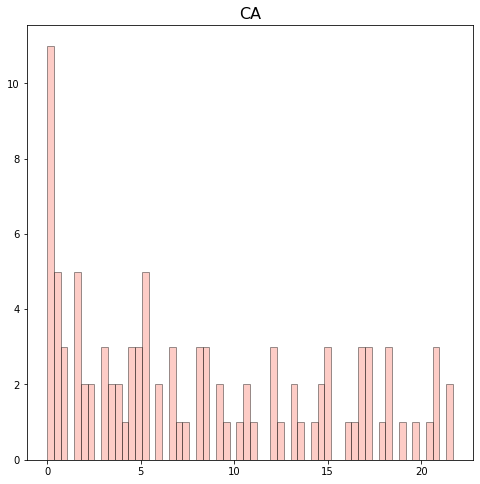

In [ ]:
plt.figure(figsize = (8,8))
plt.title('CA',fontsize = 16)
sns.distplot(Benchmark, hist=True, kde=False,
             bins=int(60), color = 'salmon',
             hist_kws={'edgecolor':'black'});

plt.show()

# Save ANN Model

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("ann_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weightandbias.h5")
print("Saved model to disk")

# later...



Saved model to disk


In [ ]:
# load json and create model
json_file = open('ann_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weightandbias.h5")
print("Loaded model from disk")

# Input : S, St, r, T, sigma, A ; Output : C Asia
# evaluate loaded model on test data
loaded_model.compile(loss="mean_squared_error",optimizer="adam",metrics = tfa.metrics.r_square.RSquare())

#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


In [ ]:
bsm_call_asia(S,K,A,T,T,r,sigma)

1.6639475717118088

In [ ]:
S_p= 105
K_p = 115
A_p = 120
T_p = 0.252
r_p = 0.03
sigma_p = 0.4
dT = 1/250

In [ ]:
scaler = StandardScaler()

In [ ]:
x_predict = [[S_p,K_p,A_p,T_p,r_p,sigma_p]]
x_predict

In [ ]:
x_predict = scaler.transform(x_predict)
x_predict

ValueError: ignored

In [ ]:
loaded_model.predict(x_predict)

In [ ]:
score = loaded_model.evaluate([[100,100,0.03,90/365,0.3,100]], [[0]])
print(score)

1/1 [==============================] - 0s 60ms/step - loss: 267.5749 - r_square: 0.0000e+00
[267.5748596191406, 0.0]


In [ ]:
score = loaded_model.evaluate([[94.4314,	94.7366,	0.0138,	0.1808,	0.15,	94.1644]],	[[0.5708238330376794]])
print(score)

1/1 [==============================] - 0s 50ms/step - loss: 532.6762 - r_square: 0.0000e+00
[532.6762084960938, 0.0]


In [ ]:
import tkinter as tk
print(tk.TkVersion)


8.6


In [ ]:
import tkinter as tk

class Calculator:
    def __init__(self, master):
        self.master = master
        master.title("Calculator")

        # Create the input field
        self.display = tk.Entry(master, width=25, justify="right", font=("Arial", 16))
        self.display.grid(row=0, column=0, columnspan=4, padx=10, pady=10)

        # Create the buttons
        self.create_button("7", 1, 0)
        self.create_button("8", 1, 1)
        self.create_button("9", 1, 2)
        self.create_button("/", 1, 3)

        self.create_button("4", 2, 0)
        self.create_button("5", 2, 1)
        self.create_button("6", 2, 2)
        self.create_button("*", 2, 3)

        self.create_button("1", 3, 0)
        self.create_button("2", 3, 1)
        self.create_button("3", 3, 2)
        self.create_button("-", 3, 3)

        self.create_button("0", 4, 0)
        self.create_button(".", 4, 1)
        self.create_button("C", 4, 2)
        self.create_button("+", 4, 3)

        self.create_button("=", 5, 0, columnspan=4)

    def create_button(self, text, row, column, columnspan=1):
        button = tk.Button(self.master, text=text, width=5, height=2, font=("Arial", 16),
                           command=lambda: self.button_click(text))
        button.grid(row=row, column=column, columnspan=columnspan, padx=5, pady=5)

    def button_click(self, text):
        if text == "C":
            self.display.delete(0, tk.END)
        elif text == "=":
            try:
                result = eval(self.display.get())
                self.display.delete(0, tk.END)
                self.display.insert(0, result)
            except:
                self.display.delete(0, tk.END)
                self.display.insert(0, "Error")
        else:
            self.display.insert(tk.END, text)

root = tk.Tk()
calculator = Calculator(root)
root.mainloop()


TclError: ignored

In [ ]:
import tkinter as tk
import math

class ScientificCalculator:
    def __init__(self, master):
        self.master = master
        master.title("Scientific Calculator")
        master.geometry("400x500")

        # Create the input field
        self.display = tk.Entry(master, width=30, justify="right", font=("Arial", 16))
        self.display.grid(row=0, column=0, columnspan=6, padx=10, pady=10)

        # Create the buttons
        button_text = ["sin", "cos", "tan", "√", "x²", "x³",
                       "log", "ln", "e", "π", "(", ")",
                       "7", "8", "9", "/", "!", "C",
                       "4", "5", "6", "*", "xⁿ", "±",
                       "1", "2", "3", "-", "1/x", "=",
                       "0", ".", "+"]

        r = 1
        c = 0
        for text in button_text:
            self.create_button(text, r, c)
            c += 1
            if c > 5:
                r += 1
                c = 0

    def create_button(self, text, row, column, columnspan=1):
        button = tk.Button(self.master, text=text, width=5, height=2, font=("Arial", 16),
                           command=lambda: self.button_click(text))
        button.grid(row=row, column=column, columnspan=columnspan, padx=5, pady=5)

    def button_click(self, text):
        if text == "C":
            self.display.delete(0, tk.END)
        elif text == "=":
            try:
                result = eval(self.display.get())
                self.display.delete(0, tk.END)
                self.display.insert(0, result)
            except:
                self.display.delete(0, tk.END)
                self.display.insert(0, "Error")
        elif text == "sin":
            value = float(self.display.get())
            result = math.sin(value)
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "cos":
            value = float(self.display.get())
            result = math.cos(value)
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "tan":
            value = float(self.display.get())
            result = math.tan(value)
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "√":
            value = float(self.display.get())
            result = math.sqrt(value)
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "x²":
            value = float(self.display.get())
            result = value ** 2
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "x³":
            value = float(self.display.get())
            result = value ** 3
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "log":
            value = float(self.display.get())
            result = math.log10(value)
            self.display.delete(0, tk.END)
            self.display.insert(0, result)
        elif text == "ln


SyntaxError: ignored